<a href="https://colab.research.google.com/github/ShivikaPrasanna/mbti-personality-prediction/blob/main/personality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
'''
Developed by Shivika Prasanna on 11/05/2021.
Last updated on 11/27/2021.
Predicts personality based on tweets.
Working code.
Dataset: /content/mbti_1.csv (download from https://www.kaggle.com/datasnaek/mbti-type)
'''
import os, sys, csv
import string, re
import argparse

import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
from nltk.classify import NaiveBayesClassifier
nltk.download('stopwords')
nltk.download('punkt')

print("Python version: ", sys.version)

dataset_path = ''

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Python version:  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


Understanding the dataset

In [46]:
df = pd.read_csv(dataset_path)

print("Dataset preview: ", df.head(10))
print("Size of the dataset: ", df.shape)

print("Preview of posts: ", df.iloc[0,1].split('|||'))
print("Length of posts: ", len(df.iloc[1,1].split('|||')))

Dataset preview:     type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...
5  INTJ  '18/37 @.@|||Science  is not perfect. No scien...
6  INFJ  'No, I can't draw on my own nails (haha). Thos...
7  INTJ  'I tend to build up a collection of things on ...
8  INFJ  I'm not sure, that's a good question. The dist...
9  INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...
Size of the dataset:  (8675, 2)
Preview of posts:  ["'http://www.youtube.com/watch?v=qsXHcwe3krw", 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg', 'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks', 'What has been

In [47]:
types = np.unique(df.type.values)
print("List of {} unique types: {}".format(len(types), types))

List of 16 unique types: ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


Total count for each personality:        posts
type       
ENFJ    190
ENFP    675
ENTJ    231
ENTP    685
ESFJ     42
ESFP     48
ESTJ     39
ESTP     89
INFJ   1470
INFP   1832
INTJ   1091
INTP   1304
ISFJ    166
ISFP    271
ISTJ    205
ISTP    337


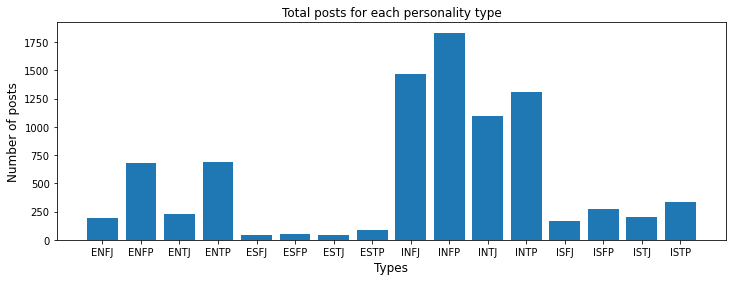

In [50]:
total_types = df.groupby(['type']).count()
print("Total count for each personality: ", total_types)

# Visualizing the counts of the types
plt.figure(figsize = (12,4))

plt.bar(np.array(total_types.index), height = total_types['posts'],)
plt.xlabel('Types', size = 12)
plt.ylabel('Number of posts', size = 12)
plt.title('Total posts for each personality type')
plt.savefig('types_counts.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


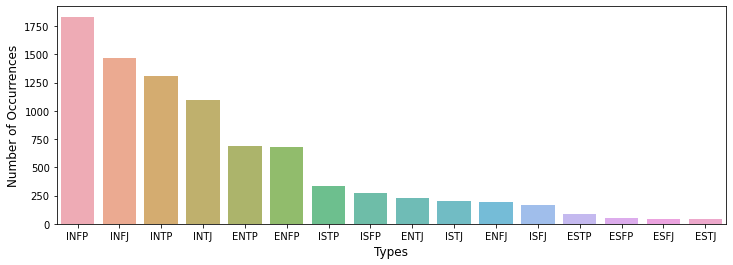

In [53]:
count_types = df['type'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(count_types.index, count_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.savefig('ordered_types_counts.png')

In [31]:
# Bag-of-words model creation: Split posts on personality and add to a Pandas Series
all_posts = pd.DataFrame()
for i in types:
    tmp1 = df[df['type'] == i]['posts']
    tmp2 = []
    for j in tmp1:
        tmp2 += j.split('|||')
    tmp3 = pd.Series(tmp2)
    all_posts[i] = tmp3
print("Preview of posts grouped by the personality type: ", all_posts.tail())

Preview of posts grouped by the personality type:                                                     ENFJ  ...                                               ISTP
9283  I am VERY particular. And I have not dated cer...  ...  Group One I tend to be sociable, but sometimes...
9284  Could you not tell the guy was INTP?  Is that ...  ...        https://www.youtube.com/watch?v=22wU-UITRIA
9285  I cannot speak for all ENFJ's, but I am hard-w...  ...  I'm trying to think... my first two detentions...
9286  Of course you do not see the point of the vide...  ...  I think you can.  You should never let your pe...
9287  The types fit because the way they use their c...  ...  I think it's just a part of human nature to ca...

[5 rows x 16 columns]


In [32]:
# Tokenize words
stop_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
def filtered_bag_of_words(words):
    words = nltk.word_tokenize(words)
    return {
        word:1 for word in words \
        if not word in stop_words
    }

print("Bag of words for type INTJ: ", filtered_bag_of_words(all_posts['INTJ'].iloc[1]))

Bag of words for type INTJ:  {'Dear': 1, 'ENTJ': 1, 'sub': 1, 'Long': 1, 'time': 1, 'see': 1, 'Sincerely': 1, 'Alpha': 1}


In [33]:
# Array of features
features = []
for i in types:
    tmp1 = all_posts[i]
    tmp1 = tmp1.dropna()
    features += [[(filtered_bag_of_words(j), i) for j in tmp1]]

In [34]:
# Splitting posts proportionally and creating a train-test set of 80:20 split
split_data = []
for i in range(16):
    split_data += [len(features[i]) * 0.8]
split_data = np.array(split_data, dtype = int)

print("Count of the split data: ", split_data)

Count of the split data:  [7430 7430 7430 7430 1614 1772 1536 3469 7430 7430 7430 7430 6496 7430
 7430 7430]


Approach 1: Split posts on personalities

In [35]:
train=[]
for i in range(16):
    train += features[i][:split_data[i]]

# Testing NB model
nb_classifier = NaiveBayesClassifier.train(train)

# Naive Bayes model accuracy
print("Naive Bayes Classifier accuracy on train set is: ", nltk.classify.util.accuracy(nb_classifier, train)*100)

test=[]
for i in range(16):
    test += features[i][split_data[i]:]

print("Naive Bayes Classifier accuracy on test set is: ", nltk.classify.util.accuracy(nb_classifier, test)*100)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("The efficiency of the model is {}, which is quite low, when we use the dataset segregated on personalities only. Instead of selecting all 16 types of personalities, a better approach would be to split the data on the 4 axes that builds the Myers Briggs personality. In other words, the 4 axes are Introversion (I) – Extroversion (E), Intuition (N) – Sensing (S), Thinking (T) – Feeling (F), Judging (J) – Perceiving (P). A classifier model would be built for each of the axes so we can predict the personality by combining 1 type from each of the axes.".format(nltk.classify.util.accuracy(nb_classifier, test)*100))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Naive Bayes Classifier accuracy on train set is:  43.91359698603765
Naive Bayes Classifier accuracy on test set is:  10.238794851632662
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The efficiency of the model is 10.238794851632662, which is quite low, when we use the dataset segregated on personalities only. Instead of selecting all 16 types of personalities, a better approach would be to split the data on the 4 axes that builds the Myers Briggs personality. In other words, the 4 axes are Introversion (I) – Extroversion (E), Intuition (N) – Sensing (S), Thinking (T) – Feeling (F), Judging (J) – Perceiving (P). A classifier model would be built for each of the axes so we can predict the personality by combining 1 type from each of the axes.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Approach 2: Predict 1 personality from each axis

In [36]:
# Changing approach to create models to predict 1 personality from each axis
# Starting with Introvert-Extrovert (IE)
features = []
for i in types:
    tmp1 = all_posts[i]
    tmp1 = tmp1.dropna()
    if('I' in i):
        features += [[(filtered_bag_of_words(j), 'introvert') for j in tmp1]]
    if('E' in i):
        features += [[(filtered_bag_of_words(j), 'extrovert') for j in tmp1]]

train = []
for i in range(16):
    train += features[i][:split_data[i]]

introvert_extrovert_model = NaiveBayesClassifier.train(train)

test = []
for i in range(16):
    test += features[i][split_data[i]:]

train_ie_model_acc = nltk.classify.util.accuracy(introvert_extrovert_model, train)*100
test_ie_model_acc = nltk.classify.util.accuracy(introvert_extrovert_model, test)*100
print("IE: Train accuracy = {}, \nTest accuracy = {} ".format(train_ie_model_acc,  test_ie_model_acc))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

IE: Train accuracy = 81.13064988563089, 
Test accuracy = 58.21297024376112 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [37]:
# Second is Intuition-Sensing (NS)
features = []
for i in types:
    tmp1 = all_posts[i]
    tmp1 = tmp1.dropna()
    if('N' in i):
        features += [[(filtered_bag_of_words(j), 'intuition') for j in tmp1]]
    if('S' in i):
        features += [[(filtered_bag_of_words(j), 'sensing') for j in tmp1]]

train = []
for i in range(16):
    train += features[i][:split_data[i]]

intuition_sensing_model = NaiveBayesClassifier.train(train)

test = []
for i in range(16):
    test += features[i][split_data[i]:]

train_ns_model_acc = nltk.classify.util.accuracy(intuition_sensing_model, train)*100
test_ns_model_acc = nltk.classify.util.accuracy(intuition_sensing_model, test)*100
print("NS: Train accuracy = {}, \nTest accuracy = {} ".format(train_ns_model_acc, test_ns_model_acc))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

NS: Train accuracy = 81.47427471355972, 
Test accuracy = 61.08926871663287 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [38]:
# Third is Thinking–Feeling (TF)
features = []
for i in types:
    tmp1 = all_posts[i]
    tmp1 = tmp1.dropna()
    if('T' in i):
        features += [[(filtered_bag_of_words(j), 'thinking') for j in tmp1]]
    if('F' in i):
        features += [[(filtered_bag_of_words(j), 'feeling') for j in tmp1]]

train = []
for i in range(16):
    train += features[i][:split_data[i]]

thinking_feeling_model = NaiveBayesClassifier.train(train)

test = []
for i in range(16):
    test += features[i][split_data[i]:]

train_tf_model_acc = nltk.classify.util.accuracy(thinking_feeling_model, train)*100
test_tf_model_acc = nltk.classify.util.accuracy(thinking_feeling_model, test)*100
print("TF: Train accuracy = {}, \nTest accuracy = {} ".format(train_tf_model_acc, test_tf_model_acc))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

TF: Train accuracy = 80.04595464566277, 
Test accuracy = 59.42142945826263 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [39]:
# Fourth is Judging–Perceiving (JP)
features = []
for i in types:
    tmp1 = all_posts[i]
    tmp1 = tmp1.dropna()
    if('J' in i):
        features += [[(filtered_bag_of_words(j), 'judging') for j in tmp1]]
    if('P' in i):
        features += [[(filtered_bag_of_words(j), 'perceiving') for j in tmp1]]

train = []
for i in range(16):
    train += features[i][:split_data[i]]

judging_perceiving_model = NaiveBayesClassifier.train(train)

test = []
for i in range(16):
    test += features[i][split_data[i]:]

train_jp_model_acc = nltk.classify.util.accuracy(judging_perceiving_model, train)*100
test_jp_model_acc = nltk.classify.util.accuracy(judging_perceiving_model, test)*100
print("JP: Train accuracy = {}, \nTest accuracy = {} ".format(train_jp_model_acc, test_jp_model_acc))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

JP: Train accuracy = 79.80686628647132, 
Test accuracy = 54.38894177047552 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Train vs Test accuracies:         Introvert - Extrovert  ...  Judging - Perceiving
train               81.13065  ...             79.806866
test                58.21297  ...             54.388942

[2 rows x 4 columns]


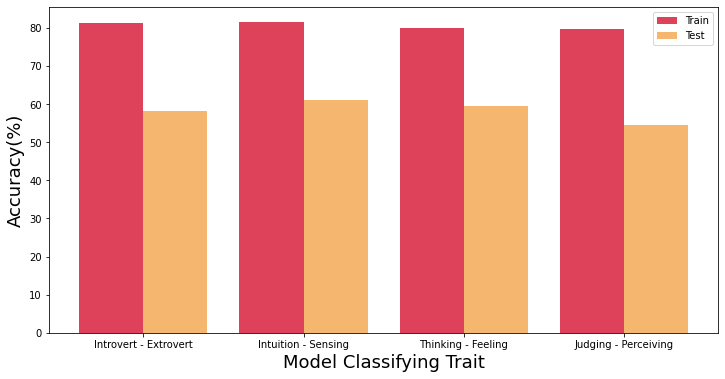

In [40]:
temp = {'train' : [train_ie_model_acc, train_ns_model_acc, train_tf_model_acc, train_jp_model_acc], 'test' : [test_ie_model_acc, test_ns_model_acc, test_tf_model_acc, test_jp_model_acc]}
test_train_acc_results = pd.DataFrame.from_dict(temp, orient='index', columns=['Introvert - Extrovert', 'Intuition - Sensing', 'Thinking - Feeling', 'Judging - Perceiving'])
print("Train vs Test accuracies: ", test_train_acc_results)

labels = np.array(test_train_acc_results.columns)

training = test_train_acc_results.loc['train']
ind = np.arange(4)
width = 0.4
fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, training, width, color='#de425b')

testing = test_train_acc_results.loc['test']
rects2 = ax.bar(ind+width, testing, width, color='#f5b66f')

fig.set_size_inches(12, 6)

ax.set_xlabel('Model Classifying Trait', size = 18)
ax.set_ylabel('Accuracy(%)', size = 18)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)
ax.legend((rects1[0], rects2[0]), ('Train', 'Test'))

fig.savefig('test_train_acc_results.png', dpi=200)

In [41]:
# Creating a function to use the above models to predict personalities
def MBTI(input):
    tokens = filtered_bag_of_words(input)
    i_e = introvert_extrovert_model.classify(tokens)
    i_s = intuition_sensing_model.classify(tokens)
    t_f = thinking_feeling_model.classify(tokens)
    j_p = judging_perceiving_model.classify(tokens)
    
    p_axis = ''
    
    if (i_e == 'introvert'):
        p_axis += 'I'
    if (i_e == 'extrovert'):
        p_axis += 'E'
    if (i_s == 'intuition'):
        p_axis += 'N'
    if (i_s == 'sensing'):
        p_axis += 'S'
    if (t_f == 'thinking'):
        p_axis += 'T'
    if (t_f == 'feeling'):
        p_axis += 'F'
    if (j_p == 'judging'):
        p_axis += 'J'
    if (j_p == 'perceiving'):
        p_axis += 'P'
    return (p_axis)

def predictMBTIPersonality(input, name):
    traits=[]
    p_ax = []

    axis1 = pd.DataFrame([0,0,0,0], ['I', 'N', 'T', 'J'], ['count'])
    axis2 = pd.DataFrame([0,0,0,0], ['E', 'S', 'F', 'P'], ['count'])

    for i in input:
        p_ax += [MBTI(i)]
    
    for i in p_ax:
        for j in ['I', 'N', 'T', 'J']:
            if (j in i):
                axis1.loc[j] += 1
        for j in ['E', 'S', 'F', 'P']:
            if (j in i):
                axis2.loc[j] += 1
    
    axis1 = axis1.T
    axis1 = axis1 * 100/len(input)
    axis2 = axis2.T
    axis2 = axis2 * 100/len(input)

    predictedTrait = ''

    for i, j in zip(axis1, axis2):
        trait_char = max(axis1[i][0], axis2[j][0])
        if (axis1[i][0] == trait_char):
            predictedTrait += i
        if (axis2[j][0] == trait_char):
            predictedTrait += j

    traits += [predictedTrait]

    labels = np.array(test_train_acc_results.columns)

    intj = axis1.loc['count']
    index = np.arange(4)
    width = 0.4
    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(index, intj, width, color='#0d729c')
    
    esfp = axis2.loc['count']
    rects2 = ax.bar(index+width, esfp, width, color='#f68657')

    fig.set_size_inches(10, 7)

    ax.set_xlabel('MBTI Trait', size = 18)
    ax.set_ylabel('Trait percent(%)', size = 18)
    ax.set_xticks(index + width/2)
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(0, 105, step= 10))
    ax.set_title(name+'\'s personality is ' + predictedTrait, size = 20)
    plt.grid(True)

    fig.savefig(name+'_results.png', dpi=200)

    return (traits)

Trait is:  ['ENTJ']


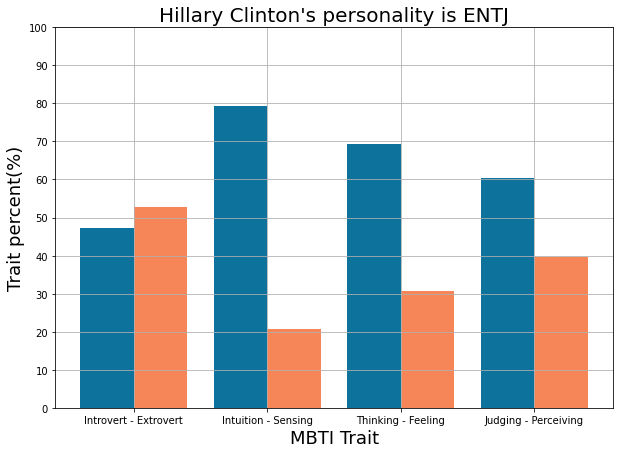

In [44]:
# Testing the above functions with tweets of famous personalities scraped from Twitter using Twarc
test_file_path = ''
name = ''

if test_file_path.endswith('.jsonl'):
    with open(test_file_path, 'r') as json_file:
        json_list = list(json_file)
        final_tweets = []

        for json_str in json_list:
            res = json.loads(json_str)
            tweet = res['full_text']
            final_tweets.append(tweet)

    predicted_trait = predictMBTIPersonality(final_tweets, name)

if test_file_path.endswith('.csv'):
    df = pd.read_csv(test_file_path)
    if 'tweet' in df.columns:
      predicted_trait = predictMBTIPersonality(df['tweet'], name)
    elif 'content' in df.columns:
      predicted_trait = predictMBTIPersonality(df['content'], name)
    elif 'text' in df.columns:
      predicted_trait = predictMBTIPersonality(df['text'], name)

if test_file_path.endswith('.txt'):
    writings = open(test_file_path, encoding='unicode_escape')
    text = writings.readlines()
    sentence = text[0].split('|||')
    predicted_trait = predictMBTIPersonality(sentence, name)

print('Trait is: ', predicted_trait)